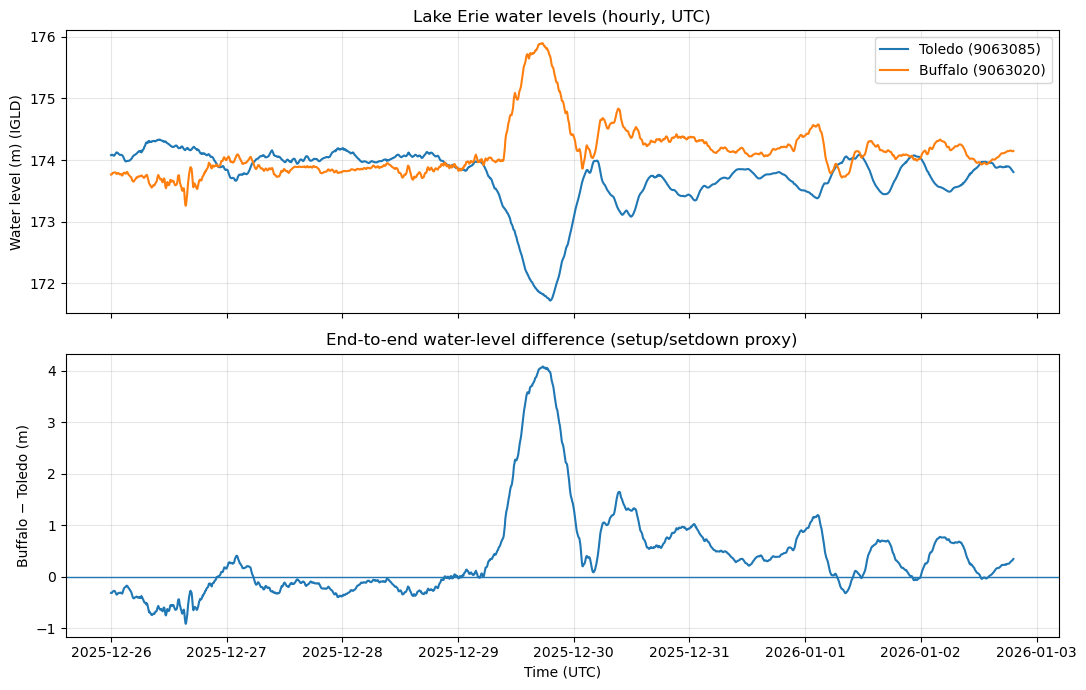

Window: 2025-12-26 00:00:00+00:00 to 2026-01-02 19:12:00+00:00
Max (Buffalo − Toledo) [m]: 4.080999999999989
Min (Buffalo − Toledo) [m]: -0.9170000000000016
Peak-to-peak diff [m]: 4.9979999999999905


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

BASE = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"  # CO-OPS Data API :contentReference[oaicite:1]{index=1}

def get_coops_water_level(
    station: str,
    begin_date: str,
    end_date: str,
    datum: str = "IGLD",      # Great Lakes datum; alternative: "MSL" if you prefer
    units: str = "metric",    # "metric" => meters, "english" => feet
    time_zone: str = "gmt",   # use GMT/UTC for clean differencing
    interval: str = "h",      # "h" hourly; "6" for 6-min; "hilo" not relevant here
    product: str = "water_level"
) -> pd.DataFrame:
    """
    Retrieve CO-OPS water level time series as a DataFrame indexed by time.
    Returns columns: ['water_level_m'] (or feet if units='english')
    """
    params = {
        "product": product,
        "application": "lagoon_seiche_script",
        "begin_date": begin_date,  # YYYYMMDD or YYYYMMDD HH:MM
        "end_date": end_date,
        "station": station,
        "datum": datum,
        "time_zone": time_zone,
        "units": units,
        "interval": interval,
        "format": "json",
    }

    r = requests.get(BASE, params=params, timeout=60)
    r.raise_for_status()
    js = r.json()

    # CO-OPS returns either 'data' or an 'error' object
    if "error" in js:
        raise RuntimeError(f"CO-OPS error for station {station}: {js['error']}")

    df = pd.DataFrame(js["data"])
    # expected keys include: 't' (time) and 'v' (value)
    df["t"] = pd.to_datetime(df["t"], utc=True)
    df["v"] = pd.to_numeric(df["v"], errors="coerce")

    col = "water_level_m" if units == "metric" else "water_level_ft"
    df = df.rename(columns={"v": col}).set_index("t").sort_index()

    # keep only the primary series column
    return df[[col]]

# -------------------------
# User inputs (edit these)
# -------------------------
# Example: "last week" relative to today (Jan 2, 2026) would be ~Dec 26, 2025 to Jan 2, 2026.
# Use whole days to avoid confusion:
begin_date = "20251226"
end_date   = "20260102"

TOLEDO  = "9063085"  # :contentReference[oaicite:2]{index=2}
BUFFALO = "9063020"  # :contentReference[oaicite:3]{index=3}

# -------------------------
# Download and align series
# -------------------------
wl_tol = get_coops_water_level(TOLEDO,  begin_date, end_date, datum="IGLD", units="metric", interval="h")
wl_buf = get_coops_water_level(BUFFALO, begin_date, end_date, datum="IGLD", units="metric", interval="h")

# Align on common timestamps
df = wl_buf.join(wl_tol, how="inner", lsuffix="_buf", rsuffix="_tol")
df["diff_buf_minus_tol_m"] = df["water_level_m_buf"] - df["water_level_m_tol"]

# Optional: remove the mean difference over the window (focus on seiche/setdown anomalies)
# df["diff_anom_m"] = df["diff_buf_minus_tol_m"] - df["diff_buf_minus_tol_m"].mean()

# -------------------------
# Plot: both sites + difference
# -------------------------
fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

axes[0].plot(df.index, df["water_level_m_tol"], label="Toledo (9063085)")
axes[0].plot(df.index, df["water_level_m_buf"], label="Buffalo (9063020)")
axes[0].set_ylabel("Water level (m) (IGLD)")
axes[0].legend(loc="best")
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Lake Erie water levels (hourly, UTC)")

axes[1].plot(df.index, df["diff_buf_minus_tol_m"])
axes[1].axhline(0, linewidth=1)
axes[1].set_ylabel("Buffalo − Toledo (m)")
axes[1].set_xlabel("Time (UTC)")
axes[1].grid(True, alpha=0.3)
axes[1].set_title("End-to-end water-level difference (setup/setdown proxy)")

plt.tight_layout()
plt.show()

# -------------------------
# Quick summary numbers
# -------------------------
print("Window:", df.index.min(), "to", df.index.max())
print("Max (Buffalo − Toledo) [m]:", df["diff_buf_minus_tol_m"].max())
print("Min (Buffalo − Toledo) [m]:", df["diff_buf_minus_tol_m"].min())
print("Peak-to-peak diff [m]:", df["diff_buf_minus_tol_m"].max() - df["diff_buf_minus_tol_m"].min())
